# Wildfire Analysis

Wildfire data: [Kaggle](https://www.kaggle.com/datasets/rtatman/188-million-us-wildfires)

Wildfire weather data: [Kaggle](https://www.kaggle.com/datasets/leternnoz/188-million-us-wildfires-weather-data)

## Import libraries

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report #tuning report for classifiers
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)





pd.set_option('display.max_columns', None)
sns.set_theme()
sns.set_palette('colorblind')

## Import data

In [3]:
df = pd.read_csv('merged_df.csv')
df.head()

/var/folders/7j/klbp4hsj1db9g3cdknqvk5300000gn/T/ipykernel_46563/3330149865.py:1: DtypeWarning: Columns (8,10,11,12,13,14,15,16,17,18,35,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('merged_df.csv')


,objectid,fod_id,fpa_id,source_system_type,source_system,nwcg_reporting_agency,nwcg_reporting_unit_id,nwcg_reporting_unit_name,source_reporting_unit,source_reporting_unit_name,local_fire_report_id,local_incident_id,fire_code,fire_name,ics_209_incident_number,ics_209_name,mtbs_id,mtbs_fire_name,complex_name,fire_year,discovery_date,discovery_doy,discovery_time,stat_cause_code,stat_cause_descr,cont_date,cont_doy,cont_time,fire_size,fire_size_class,latitude,longitude,owner_code,owner_descr,state,county,fips_code,fips_name,shape,temp_mean_0,prcp_sum_0,wspd_mean_0,temp_mean_10,prcp_sum_10,wspd_mean_10,temp_mean_30,prcp_sum_30,wspd_mean_20,temp_mean_60,prcp_sum_60,wspd_mean_60,temp_mean_180,prcp_sum_180,wspd_mean_180
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,511,Plumas National Forest,1,PNF-47,BJ8K,FOUNTAIN,NaN,NaN,NaN,NaN,NaN,2005,2453403.5,33,1300.0,9.0,Miscellaneous,2453403.5,33.0,1730.0,0.10,A,40.036944,-121.005833,5.0,USFS,CA,63.0,63.0,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...,6.9,0.0,19.3,3.970,0.0,14.170000,4.646667,39.05,10.910714,4.668421,94.9,11.946154,9.828977,287.05,10.686905
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,13,13,AAC0,PIGEON,NaN,NaN,NaN,NaN,NaN,2004,2453137.5,133,845.0,1.0,Lightning,2453137.5,133.0,1530.0,0.25,A,38.933056,-120.404444,5.0,USFS,CA,61.0,61.0,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...,6.8,0.0,9.5,10.155,5.5,13.870000,8.133333,6.00,13.038333,8.100847,6.0,11.572881,3.219101,107.50,10.496348
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,27,021,A32W,SLACK,NaN,NaN,NaN,NaN,NaN,2004,2453156.5,152,1921.0,5.0,Debris Burning,2453156.5,152.0,2024.0,0.10,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17.0,17.0,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...,17.3,0.0,NaN,12.030,0.0,9.711111,11.323333,5.50,10.455172,10.087931,6.0,11.286538,6.210651,107.50,10.915244
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,43,6,NaN,DEER,NaN,NaN,NaN,NaN,NaN,2004,2453184.5,180,1600.0,1.0,Lightning,2453189.5,185.0,1400.0,0.10,A,38.559167,-119.913333,5.0,USFS,CA,3.0,3.0,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...,14.7,0.0,6.0,14.690,0.0,7.650000,13.303333,0.00,8.930000,11.035000,0.0,10.126667,4.577326,0.00,9.742105
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,44,7,NaN,STEVENOT,NaN,NaN,NaN,NaN,NaN,2004,2453184.5,180,1600.0,1.0,Lightning,2453189.5,185.0,1200.0,0.10,A,38.559167,-119.933056,5.0,USFS,CA,3.0,3.0,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...,14.7,0.0,6.0,14.690,0.0,7.650000,13.303333,0.00,8.930000,11.035000,0.0,10.126667,4.577326,0.00,9.742105


## Exploratory Data Analysis

In [4]:
# check number of duplicates
print('Number of duplicated rows: ', df.duplicated().sum())

# drop duplicates
print('Number of rows before dropping duplicates: ', len(df))
df.drop_duplicates(inplace=True)
print('Number of rows after dropping duplicates: ', len(df))

Number of duplicated rows:  18
Number of rows before dropping duplicates:  1830945
Number of rows after dropping duplicates:  1830927


In [5]:
# check number of missing values per column
df.isnull().sum()

objectid                            0
fod_id                              0
fpa_id                              0
source_system_type                  0
source_system                       0
nwcg_reporting_agency               0
nwcg_reporting_unit_id              0
nwcg_reporting_unit_name            0
source_reporting_unit               0
source_reporting_unit_name          0
local_fire_report_id          1415632
local_incident_id              788503
fire_code                     1509471
fire_name                      923478
ics_209_incident_number       1805297
ics_209_name                  1805298
mtbs_id                       1819962
mtbs_fire_name                1819962
complex_name                  1825791
fire_year                           0
discovery_date                      0
discovery_doy                       0
discovery_time                 849910
stat_cause_code                     0
stat_cause_descr                    0
cont_date                      858023
cont_doy    

In [6]:
# check the percentage of missing values per column
columns_nulls = round(df.isnull().sum() / len(df), 2)
columns_nulls

objectid                      0.00
fod_id                        0.00
fpa_id                        0.00
source_system_type            0.00
source_system                 0.00
nwcg_reporting_agency         0.00
nwcg_reporting_unit_id        0.00
nwcg_reporting_unit_name      0.00
source_reporting_unit         0.00
source_reporting_unit_name    0.00
local_fire_report_id          0.77
local_incident_id             0.43
fire_code                     0.82
fire_name                     0.50
ics_209_incident_number       0.99
ics_209_name                  0.99
mtbs_id                       0.99
mtbs_fire_name                0.99
complex_name                  1.00
fire_year                     0.00
discovery_date                0.00
discovery_doy                 0.00
discovery_time                0.46
stat_cause_code               0.00
stat_cause_descr              0.00
cont_date                     0.47
cont_doy                      0.47
cont_time                     0.51
fire_size           

In [7]:
# get columns name that have >70% of data missing
cols_to_drop = columns_nulls[columns_nulls > 0.7].index.to_list()
cols_to_drop

['local_fire_report_id',
 'fire_code',
 'ics_209_incident_number',
 'ics_209_name',
 'mtbs_id',
 'mtbs_fire_name',
 'complex_name']

In [8]:
# drop the columns
cleaned_df = df.drop(cols_to_drop, axis=1)
cleaned_df.columns


Index(['objectid', 'fod_id', 'fpa_id', 'source_system_type', 'source_system',
       'nwcg_reporting_agency', 'nwcg_reporting_unit_id',
       'nwcg_reporting_unit_name', 'source_reporting_unit',
       'source_reporting_unit_name', 'local_incident_id', 'fire_name',
       'fire_year', 'discovery_date', 'discovery_doy', 'discovery_time',
       'stat_cause_code', 'stat_cause_descr', 'cont_date', 'cont_doy',
       'cont_time', 'fire_size', 'fire_size_class', 'latitude', 'longitude',
       'owner_code', 'owner_descr', 'state', 'county', 'fips_code',
       'fips_name', 'shape', 'temp_mean_0', 'prcp_sum_0', 'wspd_mean_0',
       'temp_mean_10', 'prcp_sum_10', 'wspd_mean_10', 'temp_mean_30',
       'prcp_sum_30', 'wspd_mean_20', 'temp_mean_60', 'prcp_sum_60',
       'wspd_mean_60', 'temp_mean_180', 'prcp_sum_180', 'wspd_mean_180'],
      dtype='object')

In [9]:
cleaned_df.head()

,objectid,fod_id,fpa_id,source_system_type,source_system,nwcg_reporting_agency,nwcg_reporting_unit_id,nwcg_reporting_unit_name,source_reporting_unit,source_reporting_unit_name,local_incident_id,fire_name,fire_year,discovery_date,discovery_doy,discovery_time,stat_cause_code,stat_cause_descr,cont_date,cont_doy,cont_time,fire_size,fire_size_class,latitude,longitude,owner_code,owner_descr,state,county,fips_code,fips_name,shape,temp_mean_0,prcp_sum_0,wspd_mean_0,temp_mean_10,prcp_sum_10,wspd_mean_10,temp_mean_30,prcp_sum_30,wspd_mean_20,temp_mean_60,prcp_sum_60,wspd_mean_60,temp_mean_180,prcp_sum_180,wspd_mean_180
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,511,Plumas National Forest,PNF-47,FOUNTAIN,2005,2453403.5,33,1300.0,9.0,Miscellaneous,2453403.5,33.0,1730.0,0.10,A,40.036944,-121.005833,5.0,USFS,CA,63.0,63.0,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...,6.9,0.0,19.3,3.970,0.0,14.170000,4.646667,39.05,10.910714,4.668421,94.9,11.946154,9.828977,287.05,10.686905
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,13,PIGEON,2004,2453137.5,133,845.0,1.0,Lightning,2453137.5,133.0,1530.0,0.25,A,38.933056,-120.404444,5.0,USFS,CA,61.0,61.0,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...,6.8,0.0,9.5,10.155,5.5,13.870000,8.133333,6.00,13.038333,8.100847,6.0,11.572881,3.219101,107.50,10.496348
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,021,SLACK,2004,2453156.5,152,1921.0,5.0,Debris Burning,2453156.5,152.0,2024.0,0.10,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17.0,17.0,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...,17.3,0.0,NaN,12.030,0.0,9.711111,11.323333,5.50,10.455172,10.087931,6.0,11.286538,6.210651,107.50,10.915244
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,6,DEER,2004,2453184.5,180,1600.0,1.0,Lightning,2453189.5,185.0,1400.0,0.10,A,38.559167,-119.913333,5.0,USFS,CA,3.0,3.0,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...,14.7,0.0,6.0,14.690,0.0,7.650000,13.303333,0.00,8.930000,11.035000,0.0,10.126667,4.577326,0.00,9.742105
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,7,STEVENOT,2004,2453184.5,180,1600.0,1.0,Lightning,2453189.5,185.0,1200.0,0.10,A,38.559167,-119.933056,5.0,USFS,CA,3.0,3.0,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...,14.7,0.0,6.0,14.690,0.0,7.650000,13.303333,0.00,8.930000,11.035000,0.0,10.126667,4.577326,0.00,9.742105


### Visualization

#### Most Frequent Causes of Wildfires

In [10]:
cause_counts = cleaned_df['stat_cause_descr'].value_counts()
cause_counts

stat_cause_descr
Debris Burning       424854
Miscellaneous        319534
Lightning            276260
Arson                273421
Equipment Use        144483
Missing/Undefined    142838
Campfire              75178
Children              60241
Smoking               52562
Railroad              32077
Powerline             14411
Fireworks             11303
Structure              3765
Name: count, dtype: int64

/var/folders/7j/klbp4hsj1db9g3cdknqvk5300000gn/T/ipykernel_46563/1389342240.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)


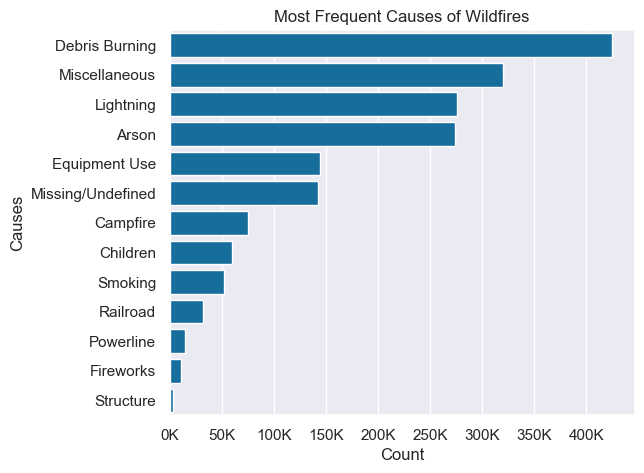

In [11]:
fig, ax = plt.subplots(figsize=(6,5))

g = sns.barplot(y=cause_counts.index, x=cause_counts.values)
g.set(title='Most Frequent Causes of Wildfires', xlabel='Count', ylabel='Causes')

xlabels = ['{:.0f}'.format(x) + 'K' for x in g.get_xticks()/1000]
g.set_xticklabels(xlabels)

plt.show()

#### Number of Wildfires per State

In [12]:
wildfires_per_state = cleaned_df['state'].value_counts()
wildfires_per_state

state
CA    185676
GA    163442
TX    141770
NC    110361
FL     88841
SC     80429
NY     80110
MS     79193
AZ     70130
AL     63626
OR     60676
MN     43909
OK     41637
MT     40499
NM     37265
ID     36499
CO     33719
WA     33375
WI     31372
AR     31311
TN     30901
SD     30705
UT     30541
LA     29080
KY     26969
NJ     25531
WV     21905
VA     21735
MO     17526
NV     16745
ND     14977
WY     14121
ME     13029
AK     12801
MI     10439
HI      9870
PA      8677
NE      7892
KS      7395
CT      4628
IA      4079
MD      3607
OH      3441
MA      2559
NH      2380
IL      2304
IN      2086
RI       480
VT       449
DE       170
DC        65
Name: count, dtype: int64

/var/folders/7j/klbp4hsj1db9g3cdknqvk5300000gn/T/ipykernel_46563/439658321.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)


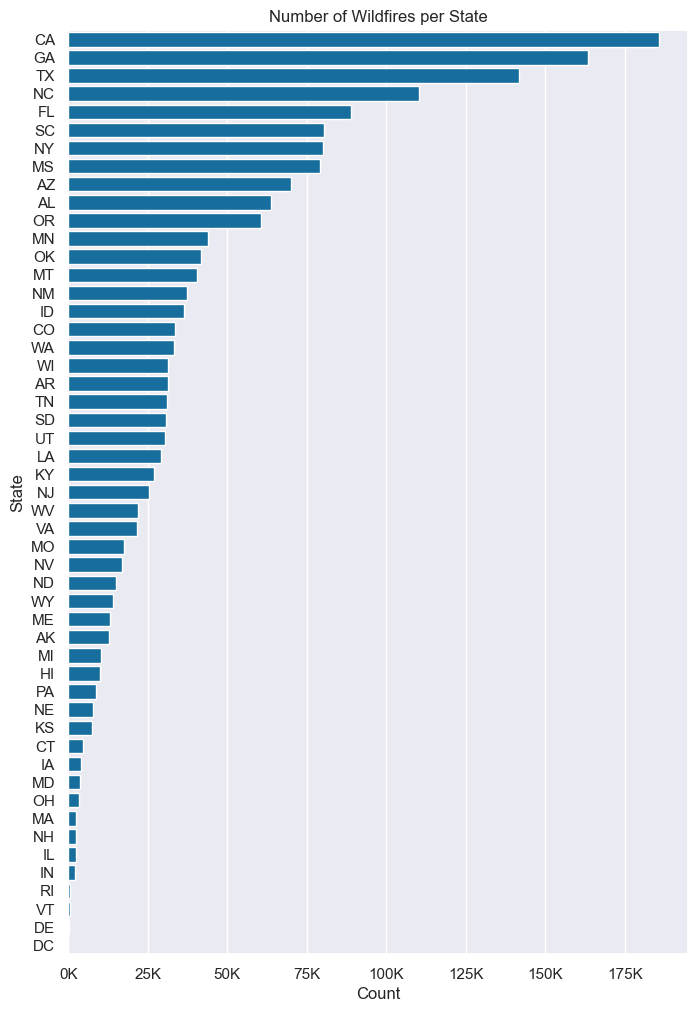

In [13]:
fig, ax = plt.subplots(figsize=(8,12))

g = sns.barplot(y=wildfires_per_state.index, x=wildfires_per_state.values)
g.set(title='Number of Wildfires per State', xlabel='Count', ylabel='State')

xlabels = ['{:.0f}'.format(x) + 'K' for x in g.get_xticks()/1000]
g.set_xticklabels(xlabels)

plt.show()

#### 

In [14]:
fire_sizes = cleaned_df['fire_size_class'].value_counts()
fire_sizes

fire_size_class
B    908052
A    654739
C    214619
D     28037
E     13965
F      7753
G      3762
Name: count, dtype: int64

/var/folders/7j/klbp4hsj1db9g3cdknqvk5300000gn/T/ipykernel_46563/1113686665.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_yticklabels(xlabels)


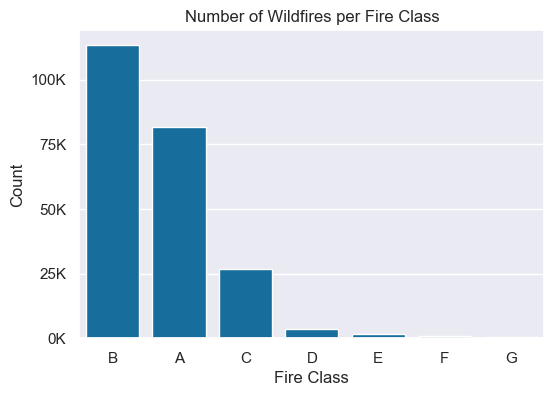

In [15]:
'''
`fire_size_class`: Code for fire size based on the number of acres within the final fire perimeter expenditures.
A=greater than 0 but less than or equal to 0.25 acres, B=0.26-9.9 acres, C=10.0-99.9 acres,
D=100-299 acres, E=300 to 999 acres, F=1000 to 4999 acres, and G=5000+ acres
'''

fig, ax = plt.subplots(figsize=(6, 4))

g = sns.barplot(x=fire_sizes.index, y=fire_sizes.values)
g.set(title='Number of Wildfires per Fire Class', xlabel='Fire Class', ylabel='Count')

ylabels = ['{:.0f}'.format(x) + 'K' for x in g.get_yticks()/1000]
g.set_yticklabels(xlabels)

plt.show()

## Building Model

In [16]:
cleaned_df.head()

,objectid,fod_id,fpa_id,source_system_type,source_system,nwcg_reporting_agency,nwcg_reporting_unit_id,nwcg_reporting_unit_name,source_reporting_unit,source_reporting_unit_name,local_incident_id,fire_name,fire_year,discovery_date,discovery_doy,discovery_time,stat_cause_code,stat_cause_descr,cont_date,cont_doy,cont_time,fire_size,fire_size_class,latitude,longitude,owner_code,owner_descr,state,county,fips_code,fips_name,shape,temp_mean_0,prcp_sum_0,wspd_mean_0,temp_mean_10,prcp_sum_10,wspd_mean_10,temp_mean_30,prcp_sum_30,wspd_mean_20,temp_mean_60,prcp_sum_60,wspd_mean_60,temp_mean_180,prcp_sum_180,wspd_mean_180
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,511,Plumas National Forest,PNF-47,FOUNTAIN,2005,2453403.5,33,1300.0,9.0,Miscellaneous,2453403.5,33.0,1730.0,0.10,A,40.036944,-121.005833,5.0,USFS,CA,63.0,63.0,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...,6.9,0.0,19.3,3.970,0.0,14.170000,4.646667,39.05,10.910714,4.668421,94.9,11.946154,9.828977,287.05,10.686905
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,13,PIGEON,2004,2453137.5,133,845.0,1.0,Lightning,2453137.5,133.0,1530.0,0.25,A,38.933056,-120.404444,5.0,USFS,CA,61.0,61.0,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...,6.8,0.0,9.5,10.155,5.5,13.870000,8.133333,6.00,13.038333,8.100847,6.0,11.572881,3.219101,107.50,10.496348
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,021,SLACK,2004,2453156.5,152,1921.0,5.0,Debris Burning,2453156.5,152.0,2024.0,0.10,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17.0,17.0,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...,17.3,0.0,NaN,12.030,0.0,9.711111,11.323333,5.50,10.455172,10.087931,6.0,11.286538,6.210651,107.50,10.915244
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,6,DEER,2004,2453184.5,180,1600.0,1.0,Lightning,2453189.5,185.0,1400.0,0.10,A,38.559167,-119.913333,5.0,USFS,CA,3.0,3.0,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...,14.7,0.0,6.0,14.690,0.0,7.650000,13.303333,0.00,8.930000,11.035000,0.0,10.126667,4.577326,0.00,9.742105
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,7,STEVENOT,2004,2453184.5,180,1600.0,1.0,Lightning,2453189.5,185.0,1200.0,0.10,A,38.559167,-119.933056,5.0,USFS,CA,3.0,3.0,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...,14.7,0.0,6.0,14.690,0.0,7.650000,13.303333,0.00,8.930000,11.035000,0.0,10.126667,4.577326,0.00,9.742105


In [17]:
wildfires_causes_df = cleaned_df[['stat_cause_code', 'stat_cause_descr']]
wildfires_causes_df = wildfires_causes_df.drop_duplicates()
wildfires_causes_df = wildfires_causes_df.reset_index(drop=True)
wildfires_causes_df

,stat_cause_code,stat_cause_descr
0,9.0,Miscellaneous
1,1.0,Lightning
2,5.0,Debris Burning
3,4.0,Campfire
4,2.0,Equipment Use
5,7.0,Arson
6,8.0,Children
7,6.0,Railroad
8,3.0,Smoking
9,11.0,Powerline


In [18]:
cleaned_df.head()

,objectid,fod_id,fpa_id,source_system_type,source_system,nwcg_reporting_agency,nwcg_reporting_unit_id,nwcg_reporting_unit_name,source_reporting_unit,source_reporting_unit_name,local_incident_id,fire_name,fire_year,discovery_date,discovery_doy,discovery_time,stat_cause_code,stat_cause_descr,cont_date,cont_doy,cont_time,fire_size,fire_size_class,latitude,longitude,owner_code,owner_descr,state,county,fips_code,fips_name,shape,temp_mean_0,prcp_sum_0,wspd_mean_0,temp_mean_10,prcp_sum_10,wspd_mean_10,temp_mean_30,prcp_sum_30,wspd_mean_20,temp_mean_60,prcp_sum_60,wspd_mean_60,temp_mean_180,prcp_sum_180,wspd_mean_180
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,511,Plumas National Forest,PNF-47,FOUNTAIN,2005,2453403.5,33,1300.0,9.0,Miscellaneous,2453403.5,33.0,1730.0,0.10,A,40.036944,-121.005833,5.0,USFS,CA,63.0,63.0,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...,6.9,0.0,19.3,3.970,0.0,14.170000,4.646667,39.05,10.910714,4.668421,94.9,11.946154,9.828977,287.05,10.686905
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,13,PIGEON,2004,2453137.5,133,845.0,1.0,Lightning,2453137.5,133.0,1530.0,0.25,A,38.933056,-120.404444,5.0,USFS,CA,61.0,61.0,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...,6.8,0.0,9.5,10.155,5.5,13.870000,8.133333,6.00,13.038333,8.100847,6.0,11.572881,3.219101,107.50,10.496348
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,021,SLACK,2004,2453156.5,152,1921.0,5.0,Debris Burning,2453156.5,152.0,2024.0,0.10,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17.0,17.0,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...,17.3,0.0,NaN,12.030,0.0,9.711111,11.323333,5.50,10.455172,10.087931,6.0,11.286538,6.210651,107.50,10.915244
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,6,DEER,2004,2453184.5,180,1600.0,1.0,Lightning,2453189.5,185.0,1400.0,0.10,A,38.559167,-119.913333,5.0,USFS,CA,3.0,3.0,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...,14.7,0.0,6.0,14.690,0.0,7.650000,13.303333,0.00,8.930000,11.035000,0.0,10.126667,4.577326,0.00,9.742105
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,7,STEVENOT,2004,2453184.5,180,1600.0,1.0,Lightning,2453189.5,185.0,1200.0,0.10,A,38.559167,-119.933056,5.0,USFS,CA,3.0,3.0,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...,14.7,0.0,6.0,14.690,0.0,7.650000,13.303333,0.00,8.930000,11.035000,0.0,10.126667,4.577326,0.00,9.742105


In [19]:
# select features and target variable
selected_features = ['fire_year', 'discovery_time', 'fire_size', 'latitude', 'longitude', 'temp_mean_0',
                     'prcp_sum_0', 'wspd_mean_0', 'temp_mean_10', 'prcp_sum_10', 'wspd_mean_10', 'temp_mean_30',
                     'prcp_sum_30', 'wspd_mean_20', 'temp_mean_60', 'prcp_sum_60', 'wspd_mean_60', 'temp_mean_180',
                     'prcp_sum_180', 'wspd_mean_180']

X = cleaned_df[selected_features]
y = cleaned_df['stat_cause_code']

In [20]:
# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=173)

In [22]:
# train model
model = RandomForestClassifier()

model.fit(X_train, y_train)

RandomForestClassifier()

In [23]:
# get predicted value on testing set
y_pred = model.predict(X_test)

In [24]:
# get accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score: %f" % accuracy)

Accuracy Score: 0.569918


In [25]:
# get feature importance
feature_importance = pd.DataFrame.from_dict({'feature_importance': model.feature_importances_,
                                             'feature':selected_features}).sort_values('feature_importance', ascending=False)
feature_importance

,feature_importance,feature
4,0.165379,longitude
3,0.130871,latitude
1,0.057629,discovery_time
2,0.055910,fire_size
0,0.054845,fire_year
17,0.046181,temp_mean_180
8,0.043886,temp_mean_10
11,0.043461,temp_mean_30
19,0.042722,wspd_mean_180
14,0.041487,temp_mean_60


In [ ]:
'''#testing by selecting only important attributes and removing lower feature importance features /
# other models produces similary weak predictions
tunedfeatures = ['fire_year', 'discovery_time', 'fire_size', 'latitude', 'longitude', 'temp_mean_0']
X1 = cleaned_df[tunedfeatures]
y1 = cleaned_df['stat_cause_code']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=173)
model1 = RandomForestClassifier()
model1.fit(X_train1, y_train1)

In [ ]:
'''#likely no effect on removing some feature engineering from training
prediction1 = model1.predict(X_test1)
print("Accuracy Score: %f" % accuracy_score(y_test1, prediction1))
feature_importance_tuning = pd.DataFrame.from_dict({'feature_importance': model1.feature_importances_,
                                             'feature':tunedfeatures}).sort_values('feature_importance', ascending=False)
feature_importance_tuning
'''

## Building Model for causes of fire in regards to Location, Time and Sizes

In [170]:
# Convert cont_time to string type
warnings.filterwarnings("ignore", message="A value is trying to be set on a copy of a slice from a DataFrame.", category=SettingWithCopyWarning)

c_model = df[["fire_year","discovery_doy","discovery_time","discovery_date","cont_doy","cont_time","stat_cause_code","stat_cause_descr","fire_size","latitude","longitude","state","fips_name"]]
c_model["cont_time"] = c_model["cont_time"].astype(str)
c_model["combined_date_dis"] = pd.to_datetime(c_model["fire_year"] * 1000 + c_model["discovery_doy"], format="%Y%j")
c_model["combined_date_dis"] = c_model["combined_date_dis"].astype(str) + " " + c_model["discovery_time"].astype(str).str[:2] + ":" + c_model["discovery_time"].astype(str).str[2:]
c_model["combined_date_dis"] = pd.to_datetime(c_model["combined_date_dis"], errors="coerce")
c_model["combined_date_con"] = pd.to_datetime(c_model["fire_year"] * 1000 + c_model["cont_doy"], format="%Y%j", errors="ignore")
c_model["combined_date_con"] = c_model["combined_date_con"].astype(str) + " " + c_model["cont_time"].str[:2] + ":" + c_model["cont_time"].str[2:]
c_model["combined_date_con"] = pd.to_datetime(c_model["combined_date_con"], errors="coerce")
c_model["duration"] = (c_model["combined_date_con"] - c_model["combined_date_dis"]).dt.seconds / 60
c_model["week_day"] = c_model["combined_date_dis"].dt.weekday
c_model["month"] = c_model["combined_date_dis"].dt.month
c_model = c_model.set_index("combined_date_dis")


#Training the model based on features ["fire_year","stat_cause_descr","fire_size","latitude","longitude","fips_name","state","duration","week_day","month"]
c_model = c_model[["fire_year","stat_cause_descr","fire_size","latitude","longitude","fips_name","state","duration","week_day","month"]]



/var/folders/7j/klbp4hsj1db9g3cdknqvk5300000gn/T/ipykernel_46563/509184395.py:9: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  c_model["combined_date_con"] = pd.to_datetime(c_model["fire_year"] * 1000 + c_model["cont_doy"], format="%Y%j", errors="ignore")
/var/folders/7j/klbp4hsj1db9g3cdknqvk5300000gn/T/ipykernel_46563/509184395.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  c_model["combined_date_con"] = pd.to_datetime(c_model["combined_date_con"], errors="coerce")


In [171]:
#remove misc/missing
c_model = c_model[~c_model['stat_cause_descr'].isin(['Miscellaneous', 'Missing/Undefined'])]
print(c_model['stat_cause_descr'])


combined_date_dis
NaT                         Lightning
2004-05-31 19:00:21    Debris Burning
2004-06-28 16:00:00         Lightning
2004-06-28 16:00:00         Lightning
2004-06-30 18:00:00         Lightning
                            ...      
2015-06-06 12:00:08     Equipment Use
NaT                    Debris Burning
NaT                          Children
2015-09-30 23:00:57             Arson
2015-08-01 13:00:31         Lightning
Name: stat_cause_descr, Length: 1368555, dtype: object


In [172]:
#label encoding and model training using RFC
fipslabelencode = LabelEncoder()
fips_labels = fipslabelencode.fit_transform(c_model.fips_name)
c_model["fips_name"] = fips_labels
statelabelencoders = LabelEncoder()
state_labels = statelabelencoders.fit_transform(c_model.state)
c_model["state"] = state_labels
encodelabel = LabelEncoder()

c_model["stat_cause_descr"] = encodelabel.fit_transform(c_model['stat_cause_descr'])
c_model["stat_cause_descr"] = c_model.stat_cause_descr.astype(int)

c_model = c_model.dropna()

#drop stat_cause_descr from training
X = c_model.drop(['stat_cause_descr'], axis=1).values 
y = c_model['stat_cause_descr'].values 
c_model.head()
X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.3, random_state=0)

ctrain = RandomForestClassifier(n_estimators=100)
ctrain.fit(X_train,Y_train)
predicted = ctrain.predict(X_test)
print("Accuracy rate: ",np.mean(predicted == Y_test))



Accuracy rate:  0.6540677450213062


In [173]:
print('Classifier accuracy check...\n', classification_report(Y_test, predicted))

#in order to maintain some level of accuracy - some inputs need to be removed from training

Classifier accuracy check...
               precision    recall  f1-score   support

           0       0.62      0.64      0.63     35573
           1       0.57      0.42      0.49     12859
           2       0.46      0.22      0.30      7449
           3       0.60      0.74      0.66     48328
           4       0.46      0.30      0.36     13017
           5       0.57      0.49      0.53      2689
           6       0.79      0.90      0.84     53338
           7       0.41      0.09      0.14      2038
           8       0.72      0.19      0.30      1999
           9       0.39      0.12      0.19      6089
          10       0.29      0.04      0.06       605

    accuracy                           0.65    183984
   macro avg       0.54      0.38      0.41    183984
weighted avg       0.63      0.65      0.63    183984



In [174]:
#check the causes to make sure misc/missing is excluded 
cause_category = encodelabel.inverse_transform([0,1,2,3,4,5,6,7,8,9,10])
print(cause_category)

['Arson' 'Campfire' 'Children' 'Debris Burning' 'Equipment Use'
 'Fireworks' 'Lightning' 'Powerline' 'Railroad' 'Smoking' 'Structure']


Feature Importance:
     Feature  Importance
3  longitude    0.253754
2   latitude    0.167588
6   duration    0.149920
8      month    0.104357
0  fire_year    0.084917
1  fire_size    0.083107
7   week_day    0.060129
4  fips_name    0.058159
5      state    0.038069


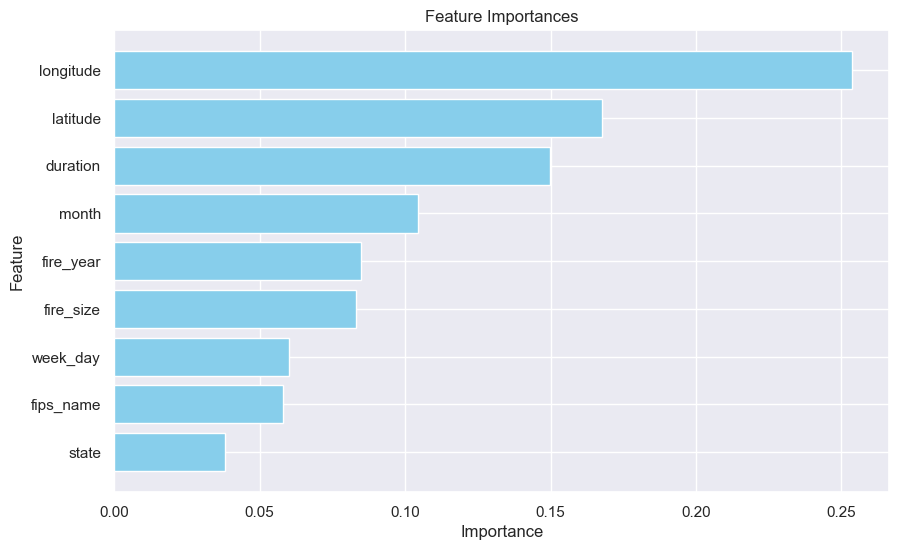

In [175]:
# Get feature importances
feature_importances = ctrain.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': c_model.drop(['stat_cause_descr'], axis=1).columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance DataFrame
print("Feature Importance:")
print(feature_importance_df)

# Plotting feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [176]:
new_data_point = {
    'fire_year':2012 ,
    'fire_size': 160,  # Assuming the fire size in acres
    'latitude': 34.0522,  # Example latitude coordinate
    'longitude': -118.2437,  # Example longitude coordinate
    'fips_name': 'Los Angeles',  # Example county name
    'state': 'NY',  # Example state abbreviation
    'duration': 12,  # Assuming the fire duration in minutes
    'week_day': 15,  # Assuming the fire was discovered on a Wednesday (0 for Monday, 6 for Sunday)
    'month': 11  # Assuming the fire was discovered in August
}

testing = pd.DataFrame([new_data_point])

testing['fips_name'] = fipslabelencode.transform(testing['fips_name'])
testing['state'] = statelabelencoders.transform(testing['state'])

predicted_cause = ctrain.predict(testing.values)
predicted_cause_description = encodelabel.inverse_transform(predicted_cause)

print("Predicted cause of fire:", predicted_cause_description)

features = c_model.drop('stat_cause_descr', axis=1)
predicted_cause = ctrain.predict(features.values)
c_model['predicted_cause'] = predicted_cause

#todo : ground truth vs prediction graph

Predicted cause of fire: ['Equipment Use']


In [177]:
# Group the data by fips_name, state, and duration
grouped = c_model.groupby(['fips_name', 'state', 'combined_date_dis'])

# Define a function to get the most common predicted cause of fire
def get_most_common_cause(group):
    return group['predicted_cause'].value_counts().idxmax()

most_common_causes = grouped.apply(get_most_common_cause).reset_index(name='most_common_cause')

print(most_common_causes)

        fips_name  state   combined_date_dis  most_common_cause
0               0     40 1998-09-16 15:00:15                  8
1               0     40 1999-11-10 16:00:30                  0
2               0     40 2000-05-20 15:00:00                  9
3               0     40 2000-05-30 15:00:35                  4
4               0     40 2000-06-06 16:00:30                  6
...           ...    ...                 ...                ...
591088       1658     50 2015-09-19 11:00:30                  3
591089       1658     50 2015-09-26 13:00:13                  3
591090       1658     50 2015-09-26 17:00:02                  6
591091       1658     50 2015-09-27 17:00:30                  3
591092       1658     50 2015-10-09 15:00:20                  3

[591093 rows x 4 columns]


/var/folders/7j/klbp4hsj1db9g3cdknqvk5300000gn/T/ipykernel_46563/1792291535.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  most_common_causes = grouped.apply(get_most_common_cause).reset_index(name='most_common_cause')
